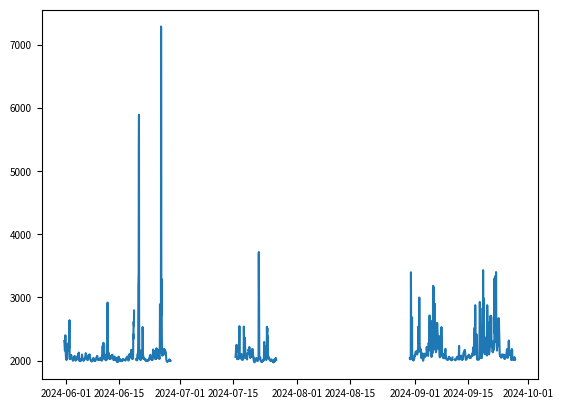

In [813]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import sys
from point_sampler import PointSampler
importlib.reload(sys.modules['point_sampler'])

landfill = (0.1436, 52.246)
lfgsource = (0.1453,  52.24259)
sewage = (0.157, 52.2335)
sampler = (0.144343, 52.237111)

sampler = tuple(reversed(sampler))
landfill = tuple(reversed(landfill))
sewage = tuple(reversed(sewage))
lfgsource = tuple(reversed(lfgsource))

data = pd.read_csv('data/msr_ch4_met_hrly_310524_270924.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date')

plt.plot(data['ch4_ppb'])

In [814]:
# Function to determine Pasquill-Gifford stability class
def determine_stability_class(row):
    hour = row['hour']
    wind_speed = row['ws']
    
    if 6 <= hour <= 18:  # Daytime hours (approx. 6 AM to 6 PM)
        if wind_speed < 2:
            return 'A'  # Very Unstable
        elif 2 <= wind_speed <= 5:
            return 'B'  # Moderately Unstable
        else:
            return 'C'  # Slightly Unstable
    else:  # Nighttime hours
        if wind_speed < 2:
            return 'F'  # Stable
        elif 2 <= wind_speed <= 5:
            return 'E'  # Slightly Stable
        else:
            return 'D'  # Neutral

data['hour'] = data.index.hour
# Apply the function to the dataframe
data['stability_class'] = data.apply(determine_stability_class, axis=1)

data.dtypes

ALTM_hPa           float64
temp               float64
DEW_C              float64
rh                 float64
wd                 float64
ws                 float64
nsec                 int64
lat                float64
lon                float64
altinmeters        float64
nsec.licor           int64
co2_ppm            float64
h2o_ppm            float64
ch4_ppb            float64
ch4_ppm            float64
latitude2          float64
longitude2         float64
hour                 int32
stability_class     object
dtype: object

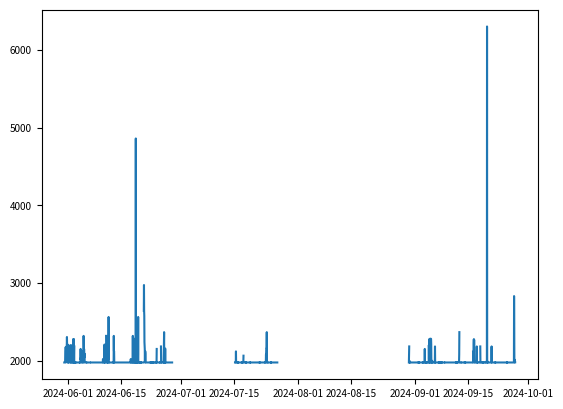

In [815]:
q_total = 40.85

centroid_point_source = PointSampler(sampler,10)
centroid_point_source.add_source(landfill,0,9)
data['pointConc'] = centroid_point_source.g_m3_to_ppm(centroid_point_source.sample_concentration(data['ws'],data['stability_class'],q_total,data['wd']))*1e3+1978
plt.plot(data['pointConc'])

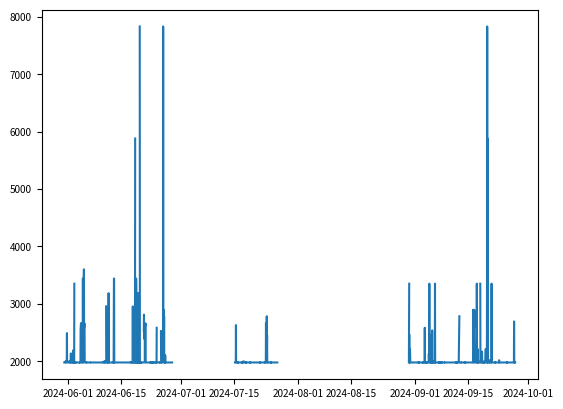

In [816]:
gasplant_point_source = PointSampler(sampler,10)
gasplant_point_source.add_source(lfgsource,0,9)
data['gasplantConc'] = gasplant_point_source.g_m3_to_ppm(gasplant_point_source.sample_concentration(data['ws'],data['stability_class'],q_total,data['wd']))*1e3+1978
plt.plot(data['gasplantConc'])

/tmp/ipykernel_131577/2128620979.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['lineConc'][data['ws'] == 0.0] = np.nan
/tmp/ipykernel_131577/2128620979.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

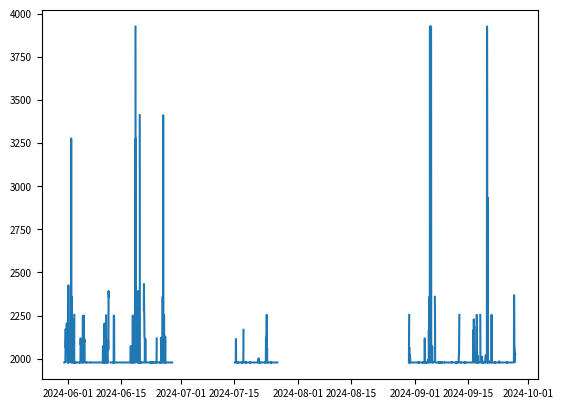

In [817]:
width = 500.0
line_source = PointSampler(sampler,10)
line_source.add_source(landfill,width,0.9)
data['lineConc'] = line_source.g_m3_to_ppm(line_source.sample_concentration(data['ws'],data['stability_class'],q_total/width,data['wd']))*1e3+1978
data['lineConc'][data['ws'] == 0.0] = np.nan
plt.plot(data['lineConc'])


date
2024-05-31 00:00:00    1978.000000
2024-05-31 01:00:00    1978.000000
2024-05-31 02:00:00    1978.000000
2024-05-31 03:00:00    1978.000000
2024-05-31 04:00:00    1978.000000
                          ...     
2024-09-27 08:00:00    2071.313724
2024-09-27 09:00:00    2058.728114
2024-09-27 10:00:00    1978.027384
2024-09-27 11:00:00    2033.988234
2024-09-27 12:00:00    2033.988234
Name: total_concentration, Length: 1648, dtype: float64


0       1978.000000
1       1978.000000
2       1978.000000
3       1978.000000
4       1978.000000
           ...     
1643    2071.313724
1644    2058.728114
1645    1978.027384
1646    2033.988234
1647    2033.988234
Length: 1648, dtype: float64

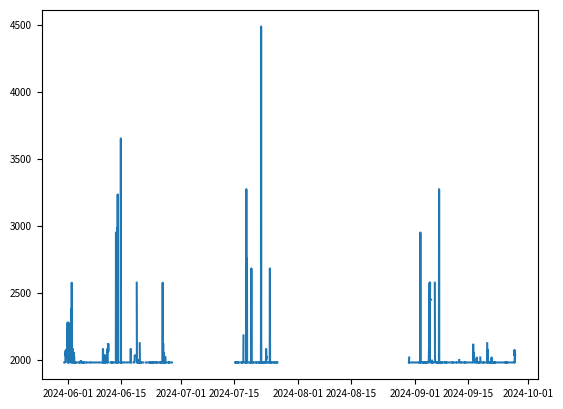

In [818]:
segs = pd.read_csv('segments_by_angle.csv')
origin = (0.1425, 52.2485)
sampler = (0.144343, 52.237111)
origin = tuple(reversed(origin))
sampler = tuple(reversed(sampler))

total_concentration = np.zeros_like(data['wd'])
segs['diffY'] = segs['Y'].diff()
segs['diffY'] = segs['diffY'].where(segs['diffY'].shift(1) == segs['diffY'], segs['diffY'].shift(1))
for i in range(19):
    current_seg = segs.iloc[i::19]
    data['wd'] = np.round(data['wd'],-1)
    merged = data.merge(current_seg, on='wd',how='left')
    each_line_sample = PointSampler(sampler, 0)
    each_line_sample.add_source(origin, merged['Length'], 0)
    merged['downwind'], merged['crosswind']= each_line_sample.get_relative_distances(merged['wd'])
    merged['downwind'] = merged['downwind'] + merged['Y']
    merged['crosswind'] = merged['crosswind'] + merged['Midpoint']
    merged['concentration'] = each_line_sample.conc_at_point(merged['downwind'], merged['crosswind'], merged['ws'],merged['stability_class'],(q_total/(100*19)))
    total_concentration += merged['concentration'] * merged['diffY']

gm3conc = total_concentration
total_concentration = total_concentration * 1e3 + 1978

data['total_concentration'] = total_concentration.values
plt.plot(data['total_concentration'])

print(data['total_concentration'])
data.shape
total_concentration

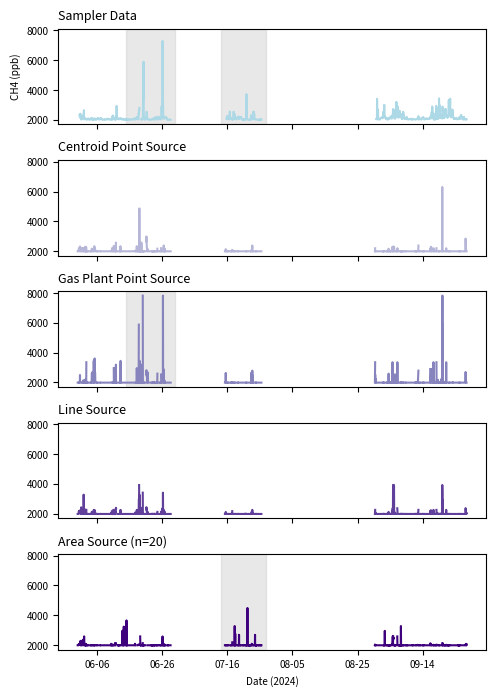

In [862]:
from matplotlib import rc
plt.style.use("default")
rc('font',**{'family':'Source Sans 3','weight':'normal','size':'8'})
fig, axs = plt.subplots(5, 1, figsize=(5, 7), sharex=True,sharey=True)

# Remove rows with NaN values in 'ch4_ppb' column
# Add vertical line to show the time break
#for ax in axs:
    #ax.axvline(pd.Timestamp('2024-07-01'), color='r', linestyle='--', label='Time Break')
# Plot actual CH4 ppb

#data.set_index('date', inplace=True)
colors = plt.cm.Purples(np.linspace(0, 1, 6))
axs[0].plot(data.index, data['ch4_ppb'], label='Sampler Data', color='lightblue')  # Make actual stand out with red color
axs[1].plot(data.index, data['pointConc'], label='Centroid Point Source', color=colors[2])
axs[2].plot(data.index, data['gasplantConc'], label='Gas Plant Point Source', color=colors[3])
axs[3].plot(data.index, data['lineConc'], label='Line Source', color=colors[4])
axs[4].plot(data.index, data['total_concentration'], label='Area Source (n=20)', color=colors[5])




axs[0].set_ylabel('CH4 (ppb)')


# Tidy the x ticks
axs[4].xaxis.set_major_locator(plt.MaxNLocator(8))
# Format x-axis to show month and day
axs[4].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))
# Combine all legends into one
handles, labels = [], []
for ax in axs:
    ax.legend()
    ax.set_title(ax.get_legend().get_texts()[0].get_text())
    tex = ax.text(0, 1.2, ax.get_title(), transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left')
    ax.set_title('')
    ax.legend_.remove()
# Set common labels
axs[0].axvspan(pd.Timestamp('2024-06-15'), pd.Timestamp('2024-06-30'), color='lightgray', alpha=0.5,zorder=-1)
axs[2].axvspan(pd.Timestamp('2024-06-15'), pd.Timestamp('2024-06-30'), color='lightgray', alpha=0.5,zorder=-100)

axs[0].axvspan(pd.Timestamp('2024-07-14'), pd.Timestamp('2024-07-28'), color='lightgray', alpha=0.5,zorder=-1)
axs[4].axvspan(pd.Timestamp('2024-07-14'), pd.Timestamp('2024-07-28'), color='lightgray', alpha=0.5,zorder=-1)
plt.xlabel('Date (2024)')
plt.tight_layout()

plt.savefig('constant_flux.png', dpi=300)
plt.show()

In [820]:
data['centrEmit']= centroid_point_source.emission_at_sampler(data['ws'],data['stability_class'],data['ch4_ppb'],data['wd'])
data['gasEmit'] = gasplant_point_source.emission_at_sampler(data['ws'],data['stability_class'],data['ch4_ppb'],data['wd'])
data['lineEmit'] = line_source.emission_at_sampler(data['ws'],data['stability_class'],data['ch4_ppb'],data['wd'])
data['areaEmit'] = data['ch4_ppb']/gm3conc.values

date
2024-05-31 00:00:00         NaN
2024-05-31 01:00:00         NaN
2024-05-31 02:00:00         NaN
2024-05-31 03:00:00         NaN
2024-05-31 04:00:00         NaN
                         ...   
2024-09-27 08:00:00    0.055307
2024-09-27 09:00:00    0.031353
2024-09-27 10:00:00    0.038878
2024-09-27 11:00:00    0.036971
2024-09-27 12:00:00    0.040908
Name: ch4_ppb, Length: 1648, dtype: float64
date
2024-05-31 00:00:00         NaN
2024-05-31 01:00:00         NaN
2024-05-31 02:00:00         NaN
2024-05-31 03:00:00         NaN
2024-05-31 04:00:00         NaN
                         ...   
2024-09-27 08:00:00    0.055307
2024-09-27 09:00:00    0.031353
2024-09-27 10:00:00    0.038878
2024-09-27 11:00:00    0.036971
2024-09-27 12:00:00    0.040908
Name: ch4_ppb, Length: 1648, dtype: float64
date
2024-05-31 00:00:00         NaN
2024-05-31 01:00:00         NaN
2024-05-31 02:00:00         NaN
2024-05-31 03:00:00         NaN
2024-05-31 04:00:00         NaN
                         ...   
2

In [821]:
#data = data_copy

In [822]:
# data = data_copy
direction_filtered = data[(data['wd']>345) | (data['wd']<20)]
data_copy = data.copy()
# data = direction_filtered

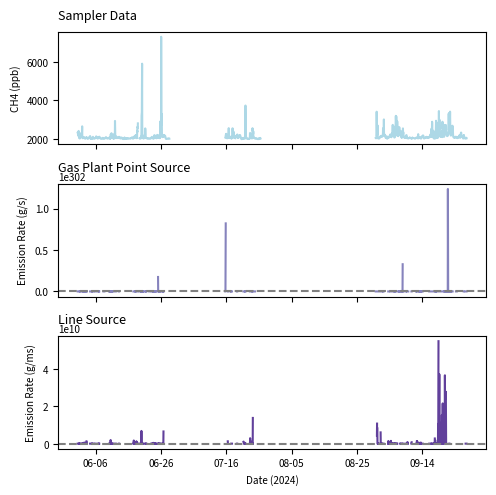

In [823]:
plt.style.use("default")
rc('font',**{'family':'Source Sans 3','weight':'normal','size':'8'})

# Remove rows with NaN values in 'ch4_ppb' column
# Add vertical line to show the time break
#for ax in axs:
    #ax.axvline(pd.Timestamp('2024-07-01'), color='r', linestyle='--', label='Time Break')
# Plot actual CH4 ppb

#data.set_index('date', inplace=True)
colors = plt.cm.Purples(np.linspace(0, 1, 6))





fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True, sharey=False)

axs[0].plot(data.index, data['ch4_ppb'], label='Sampler Data', color='lightblue')
axs[1].plot(data.index, data['gasEmit'], label='Gas Plant Point Source', color=colors[3])
axs[2].plot(data.index, data['lineEmit'], label='Line Source', color=colors[4])

axs[0].set_ylabel('CH4 (ppb)')
axs[1].set_ylabel('Emission Rate (g/s)')
axs[2].set_ylabel('Emission Rate (g/ms)')

# Tidy the x ticks
axs[2].xaxis.set_major_locator(plt.MaxNLocator(8))
# Format x-axis to show month and day
axs[2].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))
# Combine all legends into one
handles, labels = [], []
for ax in axs:
    ax.legend()
    ax.set_title(ax.get_legend().get_texts()[0].get_text())
    tex = ax.text(0, 1.2, ax.get_title(), transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='left')
    ax.set_title('')
    ax.legend_.remove()
# Set common labels
axs[1].axhline(50, color='gray', linestyle='--', label='Absolute Emission = 50')
axs[2].axhline(0.1, color='gray', linestyle='--', label='Absolute Emission = 50')
plt.xlabel('Date (2024)')
plt.tight_layout()

plt.savefig('flux_inversion.png', dpi=300)
plt.show()

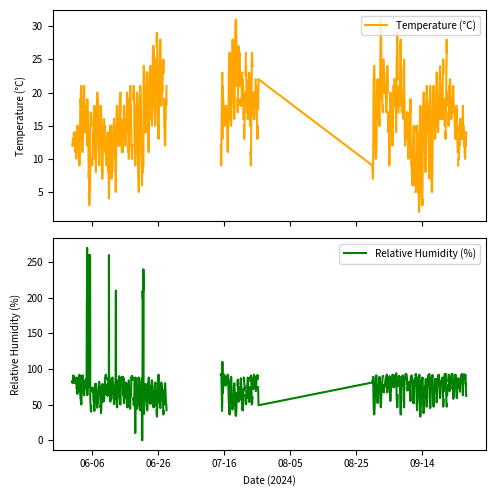

In [824]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True, sharey=False)

# Plot temperature against gas plant flux
axs[0].plot(data.index, data['temp'], label='Temperature (°C)', color='orange')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper right')

# Plot relative humidity against gas plant flux
axs[1].plot(data.index, data['rh'], label='Relative Humidity (%)', color='green')
axs[1].set_ylabel('Relative Humidity (%)')
axs[1].legend(loc='upper right')

# Set common x-axis label
plt.xlabel('Date (2024)')

# Tidy the x ticks
axs[1].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))

plt.tight_layout()
plt.show()

In [825]:
print(np.nanmean(data['lineEmit']) * 500)
print(np.nanmean(data['gasEmit'])) 

print(data.index[data['gasEmit'] >= sorted(data['gasEmit'])[-3]])

444034555017.6857
5.959821264159106e+299
DatetimeIndex(['2024-05-31 23:00:00', '2024-06-01 22:00:00',
               '2024-06-02 01:00:00', '2024-06-02 03:00:00',
               '2024-06-02 04:00:00', '2024-06-02 05:00:00',
               '2024-06-03 13:00:00', '2024-06-03 16:00:00',
               '2024-06-03 18:00:00', '2024-06-05 14:00:00',
               '2024-06-06 15:00:00', '2024-06-06 18:00:00',
               '2024-06-08 11:00:00', '2024-06-08 12:00:00',
               '2024-06-08 13:00:00', '2024-06-08 15:00:00',
               '2024-06-08 16:00:00', '2024-06-08 17:00:00',
               '2024-06-10 04:00:00', '2024-06-10 05:00:00',
               '2024-06-10 19:00:00', '2024-06-11 06:00:00',
               '2024-06-16 12:00:00', '2024-06-20 12:00:00',
               '2024-06-20 13:00:00', '2024-06-22 11:00:00',
               '2024-06-24 09:00:00', '2024-06-25 03:00:00',
               '2024-06-25 09:00:00', '2024-06-25 12:00:00',
               '2024-06-25 16:00:00', '2024-

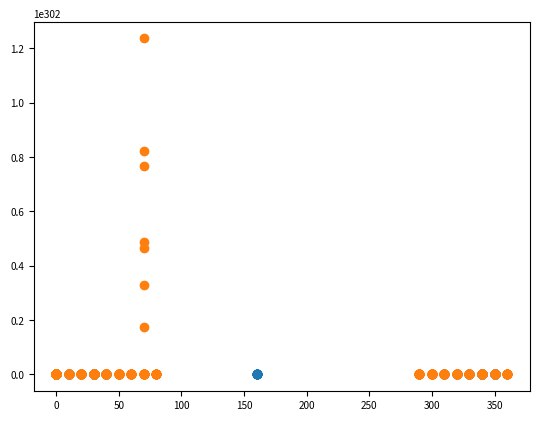

In [826]:
plt.scatter(data['wd'],data['areaEmit'])
plt.scatter(data['wd'],data['gasEmit'])

,ALTM_hPa,temp,DEW_C,rh,wd,ws,nsec,lat,lon,altinmeters,...,hour,stability_class,pointConc,gasplantConc,lineConc,total_concentration,centrEmit,gasEmit,lineEmit,areaEmit
date,,,,,,,,,,,,,,,,,,,,,
2024-06-02 17:00:00,1023.4,21.0,10.0,50.0,0.0,0.0,3926336400,52.42,0.57,10.0,...,17,A,inf,inf,NaN,NaN,0.0,0.0,1.416566e-15,NaN
2024-06-02 23:00:00,1022.7,13.0,10.0,84.0,0.0,0.0,3926358000,52.42,0.57,10.0,...,23,F,inf,inf,NaN,NaN,0.0,0.0,7.676733e-16,NaN
2024-06-03 00:00:00,1022.7,11.0,10.0,90.0,0.0,0.0,3926361600,52.42,0.57,10.0,...,0,F,inf,inf,NaN,NaN,0.0,0.0,8.691686e-16,NaN
2024-06-03 01:00:00,1022.0,11.0,9.0,87.0,0.0,0.0,3926365200,52.42,0.57,10.0,...,1,F,inf,inf,NaN,NaN,0.0,0.0,1.117426e-15,NaN
2024-06-03 23:00:00,1016.3,14.0,11.0,83.0,0.0,0.0,3926444400,52.42,0.57,10.0,...,23,F,inf,inf,NaN,NaN,0.0,0.0,1.562157e-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-18 05:00:00,1029.5,15.0,13.0,85.0,0.0,0.0,3935624400,52.42,0.57,10.0,...,5,F,inf,inf,NaN,NaN,0.0,0.0,1.775832e-14,NaN
2024-09-19 02:00:00,1026.4,16.0,14.0,91.0,0.0,0.0,3935700000,52.42,0.57,10.0,...,2,F,inf,inf,NaN,NaN,0.0,0.0,1.087618e-14,NaN
2024-09-22 05:00:00,1013.9,16.0,15.0,92.0,0.0,0.0,3935970000,52.42,0.57,10.0,...,5,F,inf,inf,NaN,NaN,0.0,0.0,2.098948e-14,NaN


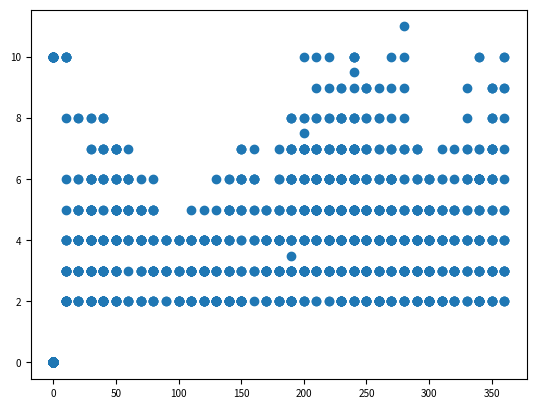

In [827]:
plt.scatter(data['wd'],data['ws'])
data[data['wd']==0]

Index(['ALTM_hPa', 'temp', 'DEW_C', 'rh', 'wd', 'ws', 'nsec', 'lat', 'lon',
       'altinmeters', 'nsec.licor', 'co2_ppm', 'h2o_ppm', 'ch4_ppb', 'ch4_ppm',
       'latitude2', 'longitude2', 'hour', 'stability_class', 'pointConc',
       'gasplantConc', 'lineConc', 'total_concentration', 'centrEmit',
       'gasEmit', 'lineEmit', 'areaEmit'],
      dtype='object')


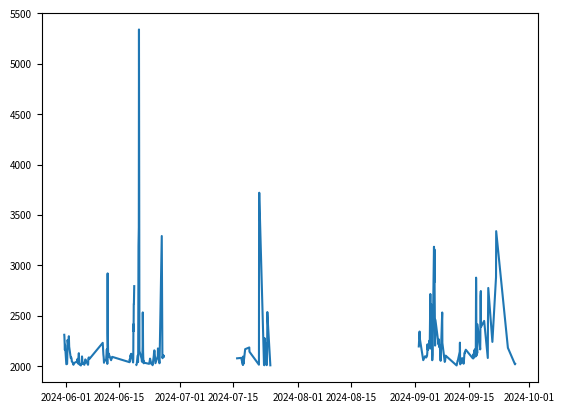

In [828]:
data_direction_filter = data[(data['wd'] < 20) | (data['wd'] > 340)]
print(data_direction_filter.columns)
plt.plot(data_direction_filter['ch4_ppb'])

date
2024-05-31 00:00:00         NaN
2024-05-31 01:00:00         NaN
2024-05-31 02:00:00         NaN
2024-05-31 03:00:00         NaN
2024-05-31 04:00:00         NaN
                         ...   
2024-09-27 08:00:00    0.055307
2024-09-27 09:00:00    0.031353
2024-09-27 10:00:00    0.038878
2024-09-27 11:00:00    0.036971
2024-09-27 12:00:00    0.040908
Name: ch4_ppb, Length: 1648, dtype: float64


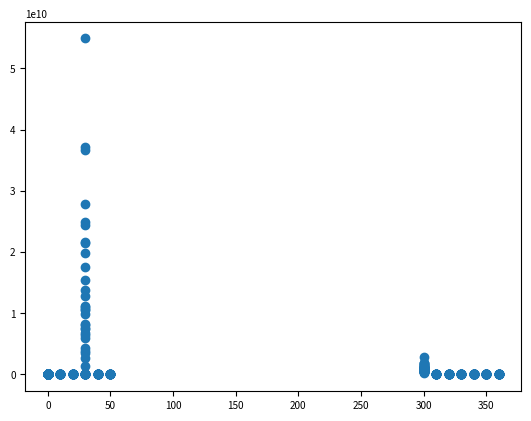

date
2024-05-31 09:00:00         NaN
2024-05-31 11:00:00         NaN
2024-05-31 12:00:00         NaN
2024-05-31 13:00:00    0.330917
2024-05-31 14:00:00    0.310061
                         ...   
2024-09-22 05:00:00    0.904607
2024-09-22 06:00:00    1.359819
2024-09-25 08:00:00    0.201329
2024-09-27 05:00:00    0.037275
2024-09-27 06:00:00    0.042113
Name: ch4_ppb, Length: 325, dtype: float64


/tmp/ipykernel_131577/139190417.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_direction_filter['emissions'] = microsoft_sampler.emission_at_sampler(data_direction_filter['ws'],data_direction_filter['stability_class'],data_direction_filter['ch4_ppb'],data_direction_filter['wd'])


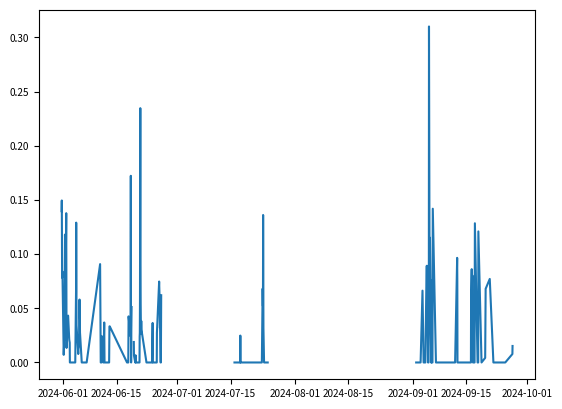

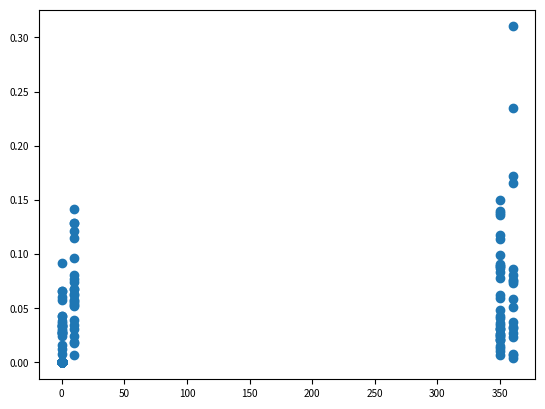

In [829]:
microsoft_sampler = PointSampler(sampler,10)
microsoft_sampler.add_source(landfill,500,0)
data['emissions'] = microsoft_sampler.emission_at_sampler(data['ws'],data['stability_class'],data['ch4_ppb'],data['wd'])
plt.scatter(data['wd'],data['emissions'])
plt.show()

data_direction_filter['emissions'] = microsoft_sampler.emission_at_sampler(data_direction_filter['ws'],data_direction_filter['stability_class'],data_direction_filter['ch4_ppb'],data_direction_filter['wd'])
plt.plot(data_direction_filter['emissions'])

plt.show()
plt.scatter(data_direction_filter['wd'],data_direction_filter['emissions'])


/tmp/ipykernel_131577/1046070855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_direction_filter['reconstructed'] = microsoft_sampler.g_m3_to_ppm(microsoft_sampler.sample_concentration(data_direction_filter['ws'],data_direction_filter['stability_class'],data_direction_filter['emissions'],data_direction_filter['wd'])) *1e3 + 1978


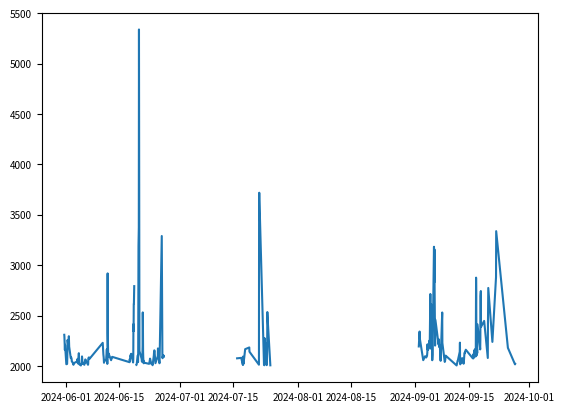

In [830]:
data_direction_filter['reconstructed'] = microsoft_sampler.g_m3_to_ppm(microsoft_sampler.sample_concentration(data_direction_filter['ws'],data_direction_filter['stability_class'],data_direction_filter['emissions'],data_direction_filter['wd'])) *1e3 + 1978
plt.plot(data_direction_filter['reconstructed'])

In [831]:
actual = data['ch4_ppb'].resample('h').mean()
reconstructed = data_direction_filter['reconstructed'].resample('h').mean()

actual_where_reconstructed = actual[~np.isnan(reconstructed)]
reconstructed = reconstructed[~np.isnan(reconstructed)]
print(np.corrcoef(actual_where_reconstructed,reconstructed))

plt.plot(unfiltered_no_nans['ch4_ppb'].resample('h').mean())
plt.plot(filtered_no_nans['reconstructed'].resample('h').mean())


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
segs = pd.read_csv('segments_by_angle.csv')
origin = (0.1425, 52.2485)
sampler = (0.144343, 52.237111)
origin = tuple(reversed(origin))
sampler = tuple(reversed(sampler))
q=1
total_concentration = np.zeros_like(data['wd'])
segs['diffY'] = segs['Y'].diff()
segs['diffY'] = segs['diffY'].where(segs['diffY'].shift(1) == segs['diffY'], segs['diffY'].shift(1))
for i in range(19):
    current_seg = segs.iloc[i::19]
    data['wd'] = np.round(data['wd'],-1)
    merged = data.merge(current_seg, on='wd',how='left')
    print(merged['diffY'])
    each_line_sample = PointSampler(sampler, 0)
    each_line_sample.add_source(origin, merged['Length']/2, 0)
    merged['downwind'], merged['crosswind']= each_line_sample.get_relative_distances(merged['wd'])
    merged['downwind'] = merged['downwind'] + merged['Y']
    merged['crosswind'] = merged['crosswind'] + merged['Midpoint']
    merged['concentration'] = each_line_sample.conc_at_point(merged['downwind'], merged['crosswind'], merged['ws'],merged['stability_class'],q)
    total_concentration += merged['concentration'] * merged['diffY']
plt.plot(data['date'], total_concentration/np.max(total_concentration))

plt.plot(data['date'], data['ch4_ppb']/np.max(data['ch4_ppb']))



0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
254   NaN
255   NaN
256   NaN
257   NaN
258   NaN
Name: diffY, Length: 259, dtype: float64
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
254   NaN
255   NaN
256   NaN
257   NaN
258   NaN
Name: diffY, Length: 259, dtype: float64
0            NaN
1      61.449638
2      61.449638
3      61.449638
4      61.449638
         ...    
254          NaN
255    61.449638
256    61.449638
257    61.449638
258          NaN
Name: diffY, Length: 259, dtype: float64
0            NaN
1      61.449638
2      61.449638
3      61.449638
4      61.449638
         ...    
254          NaN
255    61.449638
256    61.449638
257    61.449638
258          NaN
Name: diffY, Length: 259, dtype: float64
0            NaN
1      61.449638
2      61.449638
3      61.449638
4      61.449638
         ...    
254          NaN
255    61.449638
256    61.449638
257    61.449638
258          NaN
Name: diffY, Length: 259, dtype: float64
0            N

KeyError: 'date'

In [ ]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import brokenaxes as bax
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from windrose import WindroseAxes
from matplotlib import cm
from matplotlib.patheffects import withStroke

# Create a figure with 4 subplots
fig, axs = plt.subplots(4, 1, figsize=(6, 9), gridspec_kw={'height_ratios': [6, 1, 1, 1]})

# Plot the large map in the first subplot
sampler = (0.144343, 52.237111)
landfill = (0.1436, 52.246)
sewage = (0.157, 52.2335)

# Setup map
axs[0].set_axis_off()

mapax = fig.add_subplot(4, 1, 1, projection=ccrs.Mercator())
mapax.set_extent([sampler[0] - 0.020, sampler[0] + 0.020, sampler[1] - 0.012, sampler[1] + 0.012], crs=ccrs.PlateCarree())
tilemap = cimgt.OSM(cache=True)
# tilemap = cimgt.GoogleTiles(style='satellite', cache=False)
mapax.add_image(tilemap, 18)
#Plot sampling point
mapax.plot(sampler[0], sampler[1], marker='x', color='black', markersize=10, transform=ccrs.PlateCarree(), label='Sampling point',linestyle='None')

# Plot landfill and sewage points
mapax.plot([sewage[0],landfill[0]], [sewage[1],landfill[1]], marker='^', color='purple', markersize=10, transform=ccrs.PlateCarree(), label='Point Sources',linestyle='None')
# Plot highlighted polygons
polygon_coords = [
    (0.1425, 52.2485), (0.1470, 52.2470), (0.1435, 52.2435),
    (0.1510, 52.2410), (0.1500, 52.2380), (0.1370, 52.2430)
]
water_treatment_coords = [
    (0.1560, 52.2365), (0.1520, 52.2320), (0.1575, 52.2305), (0.1615, 52.2350)
]

highlight_polygon = Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='none', linewidth=1,
                            linestyle='--', label='Landfill Area', transform=ccrs.PlateCarree())
water_treatment_polygon = Polygon(water_treatment_coords, closed=True, edgecolor='black', facecolor='none',
                                  linewidth=1, linestyle='dotted', label='Sewage plant', transform=ccrs.PlateCarree())
mapax.add_patch(highlight_polygon)
mapax.add_patch(water_treatment_polygon)
gl = mapax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.2, color='black', alpha=0.7, linestyle='--')

ax.annotate('N', xy=(0.05, 0.95), xytext=(0.05, 0.85),
            arrowprops=dict(facecolor='white', edgecolor='black', linewidth=1, width=3, headwidth=5, headlength=2),
            ha='center', va='center', fontsize=30, color='white', xycoords='axes fraction',
            path_effects=[withStroke(linewidth=1, foreground='black')]
            )
# Add legend
mapax.legend(loc='upper right')
dffiltered = df.copy()
dffiltered['ALTM_hPa'] = dffiltered['ALTM_hPa'][dffiltered['ALTM_hPa'] > 100]  # Remove negative pressure values
dffiltered['rh'] = dffiltered['rh'][(dffiltered['rh'] < 100) & (dffiltered['rh']>10)]  # Remove relative humidity values above 100%
dffiltered = dffiltered.resample('1h').mean()
df1 = dffiltered
df1['temp_rolling'] = df1['temp'].ewm(span=24).mean()
df1['rh_rolling'] = df1['rh'].ewm(span=24).mean()
df1['ALTM_hPa_rolling'] = df1['ALTM_hPa'].ewm(span=24).mean()

# Remove data from the rolling averages where the last 24 points were NaN
df1['temp_rolling'] = df1['temp_rolling'].where(df1['temp'].rolling(window=24, min_periods=1).count()!=0)
df1['rh_rolling'] = df1['rh_rolling'].where(df1['rh'].rolling(window=24, min_periods=1).count()!=0)
df1['ALTM_hPa_rolling'] = df1['ALTM_hPa_rolling'].where(df1['ALTM_hPa'].rolling(window=24, min_periods=1).count()!=0)


df1[['temp_rolling']].plot(ax=axs[1], color=cm.Blues(0.8), legend=False,zorder=10)
df1[['rh_rolling']].plot(ax=axs[2], color=cm.Blues(0.7), legend=False,zorder=10)
df1[['ALTM_hPa_rolling']].plot(ax=axs[3], color=cm.Blues(0.6), legend=False,zorder=10)

# Plot the actual data on each subplot in grey
df1[['temp']].plot(ax=axs[1], color='grey', legend=False,alpha=0.5)
df1[['rh']].plot(ax=axs[2], color='grey', legend=False,alpha=0.5)
df1[['ALTM_hPa']].plot(ax=axs[3], color='grey', legend=False,alpha=0.5)

# Add a single legend for all subplots
lines_labels = [axs[1].get_legend_handles_labels(), axs[2].get_legend_handles_labels(), axs[3].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, ['Parameter', '24h Rolling Average'], loc='upper center',bbox_to_anchor=(0.53,0.47),ncol=3)
# Plot the time series of meteorological parameters in the remaining subplots
axs[1].set_ylabel('Temperature (°C)')
axs[1].set_xlabel('Date')

axs[2].set_ylabel('Relative \n Humidity (%)')
axs[2].set_xlabel('Date')



axs[3].set_ylabel('Atmospheric \n Pressure (hPa)')
axs[3].set_xlabel('Date')

# Add an inset wind rose in the bottom left of the first subplot
wrax = inset_axes(
    mapax,
    width=1.3,  # size in inches
    height=1.3,  # size in inches
    loc="lower left",  # position
    axes_class=WindroseAxes,  # specify the class of the axe
    bbox_transform=mapax.transAxes,
    bbox_to_anchor=(0.07, 0.07)
)

blueshort = truncate_colormap(cm.Blues,0.2,1)

wrax.bar(df['wd'], df['ws'], normed=True, opening=1, nsector=16, cmap=blueshort, alpha=1,zorder=100)
wrax.set_legend()
wrax.legend(title='Wind Speed (m/s)', loc='upper left', bbox_to_anchor=(-0.76, 0.46), frameon=True, framealpha=1)
wrax.get_legend().get_frame().set_linewidth(0.0)

bbox = dict(boxstyle="round", ec="white", fc="white", alpha=1)
plt.setp(wrax.get_xticklabels(), bbox=bbox)

wrax.get_xaxis().set_ticks(np.radians([90,180,270,360]),labels=["N","W","S","E"])
wrax.get_yaxis().set_ticks([5,10,15,20],labels=["","","",""])
for axis in [wrax.get_xaxis(), wrax.get_yaxis()]:
    axis.set_zorder(-2000)
wrax.patch.set_alpha(0.5)
# Adjust layout
plt.tight_layout()

wrax.set_rlabel_position(pos-150)

fig.align_ylabels(axs)
# Save the figure
plt.savefig('map_and_meteorological_parameters.png', dpi=300)
plt.show()

In [ ]:
import matplotlib.cm as cm

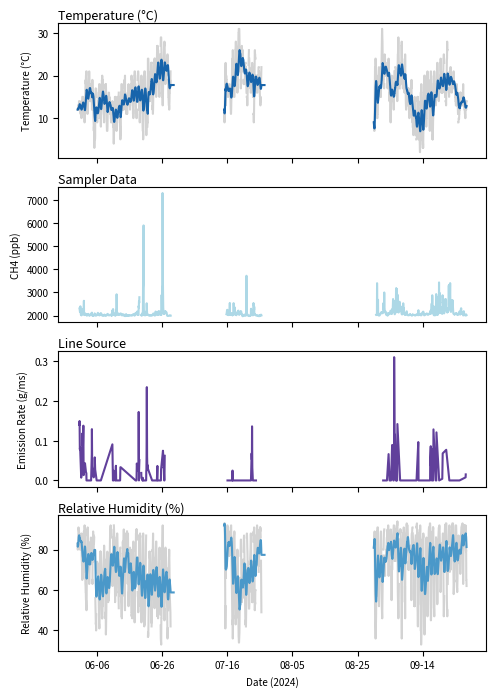

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(5, 7), sharex=True, sharey=False)

data_t = data['temp'].resample('1h').mean()
# Plot temperature and rolling average
axs[0].plot(data_t.index, data_t, label='Temperature (°C)', color='lightgray')
axs[0].plot(data_t.index, data_t.ewm(span=24).mean().where(data_t.rolling(window=24, min_periods=1).count()!=0), label='24h Rolling Avg', color=cm.Blues(0.8))
axs[0].set_ylabel('Temperature (°C)')

# Plot actual CH4 ppb
colors = plt.cm.Purples(np.linspace(0, 1, 6))
axs[1].plot(data.index, data['ch4_ppb'], label='Sampler Data', color='lightblue')
axs[2].plot(direction_filtered.index, direction_filtered['lineEmit'], label='Line Source', color=colors[4])

# Set labels
axs[1].set_ylabel('CH4 (ppb)')
axs[2].set_ylabel('Emission Rate (g/ms)')
axs[3].set_ylabel('Relative Humidity (%)')

# Tidy the x ticks
axs[3].xaxis.set_major_locator(plt.MaxNLocator(8))
axs[3].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m-%d'))

data_rh = data['rh']
data_rh = data_rh[data_rh < 100][data_rh > 10]
data_rh = data_rh.resample('1h').mean()
axs[3].plot(data_rh.index, data_rh, label='Relative Humidity (%)', color='lightgray')
axs[3].plot(data_rh.index, data_rh.ewm(span=24).mean().where(data_rh.rolling(window=24, min_periods=1).count()!=0), label='24h Rolling Avg', color=cm.Blues(0.6))
axs[3].set_ylabel('Relative Humidity (%)')

# Set common labels
# Combine all legends into one
handles, labels = [], []
for ax in axs:
    ax.legend()
    ax.set_title(ax.get_legend().get_texts()[0].get_text())
    tex = ax.text(0, 1.1, ax.get_title(), transform=ax.transAxes, fontsize=10,
                  verticalalignment='top', horizontalalignment='left')
    ax.set_title('')
    ax.legend_.remove()
 
# Set common labels
plt.xlabel('Date (2024)')
plt.tight_layout()

plt.savefig('atmos.png', dpi=300)
plt.show()
   # Resample relative humidity and calculate rolling average
